# VE7CC - Data from first quarter of 2019

We're interested in the question: at what point during a day will we have the best chance of reaching Europe on 20m via CW?  As a proxy for that question, we'll tackle the inverse: when does the local skimmer (VE7CC) have the best chance of hearing CQs from Europe on 20m?  

Here we'll examine the data from January 1 - March 31 2019, and see if we can build a model that will predict this.  Initially we'll see if there's a relationship between time of day and likelihood of hearing Europe.  This will almost certainly change over the course of those three months, due to changing daylight hours, so adding sunrise/sunset as a factor will become necessary pretty quickly.  We'll also look for ways to bring in historical data for sunspot indexes (though since we're at the bottom of a sunspot cycle, this may not be as useful as it would be in other years).


Let's start with some standard imports.

In [1]:
import pandas as pd
import numpy as np

# Make plots bigger
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
%matplotlib inline

# Now seaborn
import seaborn as sns
# I like this. :-) 
sns.set_palette("bright")


*Note:* Rather than load data from the RBN every time, the first three months of data was fetched once like so:

```
python src/data/rbn.py download --range 20190301-20190331 --unzip
```

This is current commented out in the Makefile; you can uncomment it to run it.

Now let's load the dataset:

In [2]:
from src.data.load_dataset import load_dataset

data_file = '../data/interim/ve7cc_eu.csv'
data = load_dataset(data_file)
data.drop(data.index[-1], inplace=True)
data.head()

callsign de_pfx de_cont    freq band      dx dx_pfx  \
date                                                                      
2019-01-01 00:44:57  VE7CC-7     VE      NA  3520.0  80m     M0I      G   
2019-01-01 00:47:57    VE7CC     VE      NA  7084.1  40m  UR5EUI     UR   
2019-01-01 01:00:08  VE7CC-7     VE      NA  3562.0  80m   I4OSH      I   
2019-01-01 01:06:49    VE7CC     VE      NA  7084.1  40m  UR5EUI     UR   
2019-01-01 01:58:51    VE7CC     VE      NA  3536.5  80m  TA1WCC    TA1   

                    dx_cont mode  db  speed tx_mode  
date                                                 
2019-01-01 00:44:57      EU   CQ   9     23      CW  
2019-01-01 00:47:57      EU   CQ  22     44      CW  
2019-01-01 01:00:08      EU   CQ  15     18      CW  
2019-01-01 01:06:49      EU   CQ  19     42      CW  
2019-01-01 01:58:51      EU   CQ  13     18      CW

In [3]:
data.tail()

callsign de_pfx de_cont    freq band     dx dx_pfx  \
date                                                                     
2019-03-30 23:35:56    VE7CC     VE      NA  7022.0  40m  EA5KV     EA   
2019-03-30 23:44:57    VE7CC     VE      NA  7022.0  40m  EA5KV     EA   
2019-03-31 00:45:30  VE7CC-7     VE      NA  7022.8  40m  IY6ML      I   
2019-03-31 02:39:36  VE7CC-7     VE      NA  7038.0  40m    M0I      G   
2019-03-31 02:39:36    VE7CC     VE      NA  7038.0  40m    M0I      G   

                    dx_cont mode  db  speed tx_mode  
date                                                 
2019-03-30 23:35:56      EU   CQ   7     30      CW  
2019-03-30 23:44:57      EU   CQ   8     29      CW  
2019-03-31 00:45:30      EU   CQ   6     26      CW  
2019-03-31 02:39:36      EU   CQ  20     24      CW  
2019-03-31 02:39:36      EU   CQ  24     24      CW

What bands are we receiving on?

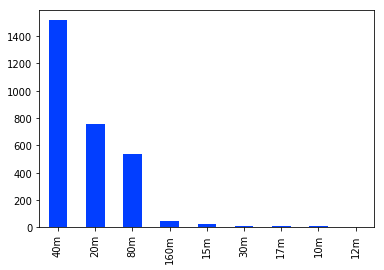

In [4]:
data.band.value_counts().plot(kind='bar')

Since we seem to have a lot of 40m, 20m and 80m contacts, let's start by dropping the rest.

In [5]:
# FIXME: there must be better ways to do this.
data_40m = data[data.band == '40m'].dropna()
data_20m = data[data.band == '20m'].dropna()
data_80m = data[data.band == '80m'].dropna()
data2 = pd.concat([data_40m, data_20m, data_80m])
data2.head()

callsign de_pfx de_cont    freq band      dx dx_pfx  \
date                                                                      
2019-01-01 00:47:57    VE7CC     VE      NA  7084.1  40m  UR5EUI     UR   
2019-01-01 01:06:49    VE7CC     VE      NA  7084.1  40m  UR5EUI     UR   
2019-01-01 18:24:48    VE7CC     VE      NA  7015.1  40m  JW5NNS     JW   
2019-01-01 22:55:43    VE7CC     VE      NA  7013.9  40m   OK2RZ     OK   
2019-01-01 23:17:05    VE7CC     VE      NA  7035.0  40m   EW1TS     EU   

                    dx_cont mode  db  speed tx_mode  
date                                                 
2019-01-01 00:47:57      EU   CQ  22     44      CW  
2019-01-01 01:06:49      EU   CQ  19     42      CW  
2019-01-01 18:24:48      EU   CQ  14     27      CW  
2019-01-01 22:55:43      EU   CQ  10     26      CW  
2019-01-01 23:17:05      EU   CQ  11     13      CW

**FIXME:** These next two functions are copied from other notebooks, and should almost certainly be broken out into a library.  They're a bit different -- I've changed them so that they're no longer graphing by column.

In [6]:
def group_by_hour(df):
    "Group dataframe by hour, summing by band and dx_continent"
    df = df['db'].groupby([df.index.hour, df.dx_pfx, df.dx_cont]).count().fillna(0).reset_index()
    return df

def graph_by_hour(df):
    "Graph dataframe by hour, summing by band and dx_cont"
    ax = sns.relplot(x='date', y='db', kind='line', height=8, data=group_by_hour(df))
    # Set the labels for the axes appropriately.
    ax.set(xlabel='Hour (UTC)', ylabel='Stations heard')

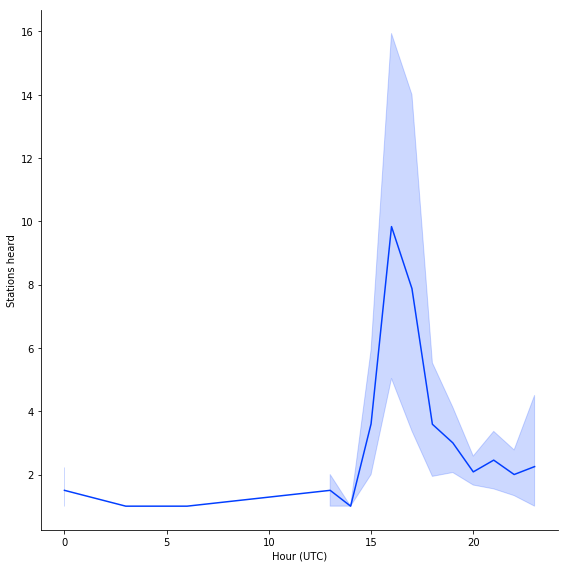

In [7]:
graph_by_hour(data_20m)

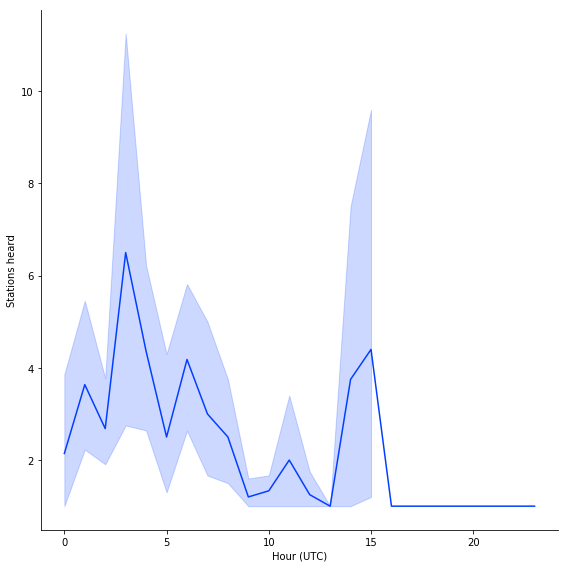

In [8]:
graph_by_hour(data_80m)

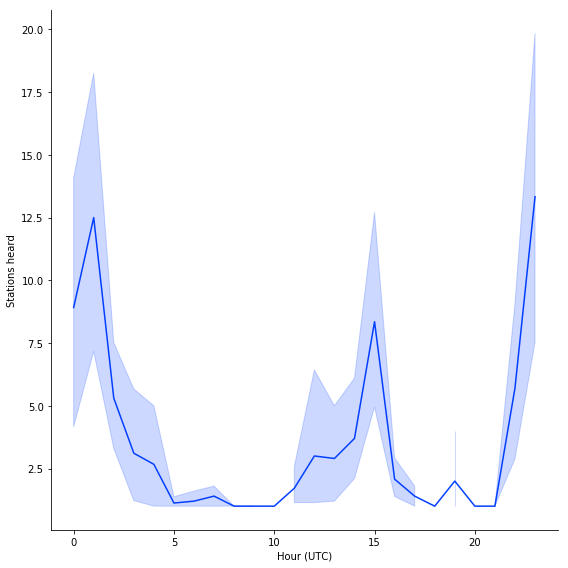

In [9]:
graph_by_hour(data_40m)

To graph all the bands together, we need to adjust the legend so that it does not show unused categories.  (Originally I'd tried using `remove_unused_categories()` or `dropna()`, but these turned out to be difficult to figure out.) To do that, we set the legend manually, passing `d2f.band.unique()` as the labels.  

**FIXME:** I am *not* sure why the labels seem to line up -- as in, why (I'm pretty sure) the bands are labelled correctly.  Is this coincidence or something else?

**FIXME:** Yet another copy of graph_by_hour/group_by_hour, subtly different.

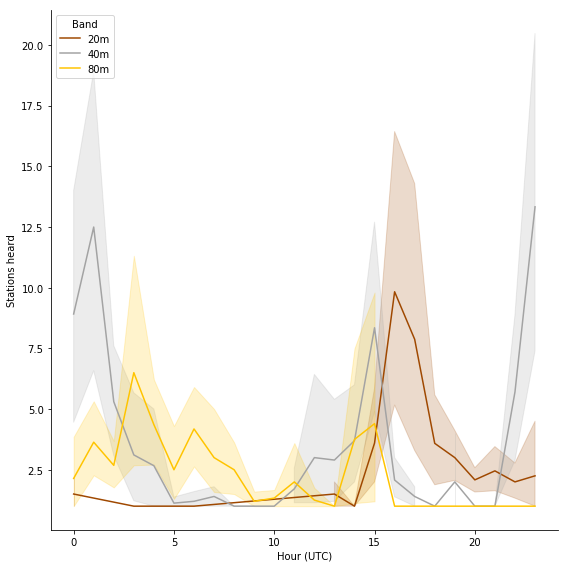

In [10]:
d2f = data2['db'].groupby([data2.index.hour, data2.band, data2.dx_pfx, data2.dx_cont]).count().dropna().reset_index()
ax = sns.relplot(x='date', y='db',hue='band',kind='line', height=8, data=d2f, legend=False)
ax.set(xlabel='Hour (UTC)', ylabel='Stations heard')
plt.legend(title='Band', loc='upper left', labels=d2f.band.unique())

So -- here's what we've found so far:

- There are definite peaks and valleys for the different bands.
- The ranges follow the shape of the mean (**FIXME:** I presume that's what the center line is in each of those), but expand and contract a *lot*.  IOW, there's a very wide range in the number of contacts.  For example:
  - 20m at its peak (1600 - 1700) has a range of 12 (min 5, max 17); just a few hours later (2000), that shrinks to 1.
  - 40m at its peak (0100 has a range of 11 (min 7, max 18); again, a few hours later that shrinks to 1.
- The highest possibility of hearing Europe is on 40m; this includes both the entire range and the mean.  20m is close; 80m is behind that.

There are some improvements to the graph that could be made:

- X ticks in multiples of 2, 4 or 6 instead of 5
- Not using relgraph for the band graphs (which is for comparing different categories), but using the underlying type more directly
- Ensuring I understand what's happening with the legend (which may come down to not using relgraph and letting seaborn take care of the legend again)
- We're focusing on change over the course of a day; what about day of the week, month, season, etc?

And there are improvements that could be made to the code:

- turn the graph_by functions into libraries
- reducing the copy-paste approach to munging the data frames for graphing
- separating, then combining the data frames by band; it's possible this is not even necessary.


Rather than work on that right now, I'm inclined to switch to trying to create a model. 